In [1]:
%autosave 180
%load_ext autoreload
%autoreload 2

Autosaving every 180 seconds


# Imports

In [2]:
import random

from features import get_time_features
from utils import get_target
import os
import gc

import pandas as pd
pd.set_option('max_columns', None)

import numpy as np
from scipy import stats
from copy import deepcopy
import category_encoders as ce
from feature_engine.creation import CyclicalTransformer
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline

from reducing import Reducer
from features import num_transformations
from utils import downcast

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [3]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from utils import get_target

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Parameters

In [4]:
USE_FULL = True

data_path = 'data'
train_filename = 'training_set_VU_DM.csv'
test_filename = 'test_set_VU_DM.csv'

drop_cols = ['position', 'click_bool',
             'gross_bookings_usd', 'booking_bool',
#              'train', 'val', 'test', 'subm'
             ]

group_col = 'srch_id'
time_col = 'date_time'

CLIP_PRICE = 15000  # None
FILTER_PRICE_SIGMA = 4  # 4 or None

COMP_RATE_PERCENT_DIFF_SIGNED_FEATURES = True
COMP_RATE_PERCENT_DIFF_TRANSFORMATION_FEATURES = False

BOOKING_TIME_FEATURES = False
BOOKING_TIME_CYCLICALS = False

HOLIDAY_DURING_TRIP_FEATURE = False
HOLIDAY_DURING_BOOKING_FEATURE = False
if HOLIDAY_DURING_TRIP_FEATURE or HOLIDAY_DURING_BOOKING_FEATURE:
    from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

# Data reading

In [5]:
dtps = {'srch_id': 'uint32',
        'date_time': 'object',
        'site_id': 'uint8',
        'visitor_location_country_id': 'uint8',
        'visitor_hist_starrating': 'float32',
        'visitor_hist_adr_usd': 'float32',
        'prop_country_id': 'uint8',
        'prop_id': 'uint32',
        'prop_starrating': 'float32',
        'prop_review_score': 'float32',
        'prop_brand_bool': 'uint8',
        'prop_location_score1': 'float32',
        'prop_location_score2': 'float32',
        'prop_log_historical_price': 'float32',
        'position': 'uint8',
        'price_usd': 'float32',
        'promotion_flag': 'uint8',
        'srch_destination_id': 'uint16',
        'srch_length_of_stay': 'uint8',
        'srch_booking_window': 'uint16',
        'srch_adults_count': 'uint8',
        'srch_children_count': 'uint8',
        'srch_room_count': 'uint8',
        'srch_saturday_night_bool': 'uint8',
        'srch_query_affinity_score': 'float32',
        'orig_destination_distance': 'float32',
        'random_bool': 'uint8',
        'comp1_rate': 'Int8',
        'comp1_inv': 'float32',
        'comp1_rate_percent_diff': 'float32',
        'comp2_rate': 'Int8',
        'comp2_inv': 'float32',
        'comp2_rate_percent_diff': 'float32',
        'comp3_rate': 'Int8',
        'comp3_inv': 'float32',
        'comp3_rate_percent_diff': 'float32',
        'comp4_rate': 'Int8',
        'comp4_inv': 'float32',
        'comp4_rate_percent_diff': 'float32',
        'comp5_rate': 'Int8',
        'comp5_inv': 'float32',
        'comp5_rate_percent_diff': 'float32',
        'comp6_rate': 'Int8',
        'comp6_inv': 'float32',
        'comp6_rate_percent_diff': 'float32',
        'comp7_rate': 'Int8',
        'comp7_inv': 'float32',
        'comp7_rate_percent_diff': 'float32',
        'comp8_rate': 'Int8',
        'comp8_inv': 'float32',
        'comp8_rate_percent_diff': 'float32',
        'click_bool': 'uint8',
        'gross_bookings_usd': 'float32',
        'booking_bool': 'uint8'}

In [6]:
from features_dict import features

if USE_FULL:
    df = pd.read_csv(os.path.join(data_path, train_filename),
                     dtype=dtps,
                     )
else:
#     p = 0.01
#     df = pd.read_csv(os.path.join(data_path, train_filename),
#                      #                      usecols=features['original_cols'],
#                      skiprows=lambda i: i > 0 and random.random() > p)
    df = pd.read_csv(os.path.join(data_path, train_filename),
                     dtype=dtps,
                     )
    df = df[df[group_col] < 33428]
df.shape

(4958347, 54)

In [7]:
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3.0,3.5,1,2.83,0.0438,4.95,27,104.769997,0,23246,1,0,4,0,1,1,NaN,NaN,1,<NA>,NaN,NaN,0,0.0,NaN,0,0.0,NaN,<NA>,NaN,NaN,0,0.0,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4.0,4.0,1,2.20,0.0149,5.03,26,170.740005,0,23246,1,0,4,0,1,1,NaN,NaN,1,<NA>,NaN,NaN,<NA>,NaN,NaN,0,0.0,NaN,<NA>,NaN,NaN,0,1.0,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,0,0.0,NaN,0,NaN,0


In [8]:
if USE_FULL:
    subm_df = pd.read_csv(os.path.join(data_path, test_filename),
                          dtype=dtps
                          )
else:
    p = 0.01
    subm_df = pd.read_csv(os.path.join(data_path, test_filename),
#                           usecols=features['original_cols'],
                          skiprows=lambda i: i > 0 and random.random() > p)
subm_df.shape

(4959183, 50)

In [9]:
intersection_groups = set(df[group_col]).intersection(set(subm_df[group_col]))

In [10]:
len(intersection_groups), len(intersection_groups)/len(set(df[group_col])), len(intersection_groups)/len(set(subm_df[group_col]))

(119914, 0.600185189819565, 0.6009250860690858)

# Split train, test, val (only add labels, keep the data in one df)

In [11]:
df['test'] = False
df.loc[(df[group_col] % 100).isin([0,1,2,3,4,5]), 'test'] = True

df['val'] = False
df.loc[(df[group_col] % 100).isin([6,7,8,9,10]), 'val'] = True

df['train'] = False
df.loc[(~df['test']) & (~df['val']), 'train'] = True

# df['test'] = False
# df.loc[df[group_col] % 10 == 5, 'test'] = True

# df['val'] = False
# df.loc[df[group_col] % 10 == 1, 'val'] = True

# df['train'] = False
# df.loc[(~df['test']) & (~df['val']), 'train'] = True

In [12]:
len_train = len(df[df['train']])
len_val = len(df[df['val']])
len_test = len(df[df['test']])

total_len = len_train + len_val + len_test
assert total_len == len(df)
len_train/len(df), len_val/len(df), len_test/len(df)

(0.8893951956166036, 0.05057774294538079, 0.06002706143801553)

In [13]:
df['subm']= False
subm_df['subm'] = True
df = pd.concat([df, subm_df])

df['date_time'] = pd.to_datetime(df['date_time'])

df['train'].fillna(False, inplace=True)
df['test'].fillna(False, inplace=True)
df['val'].fillna(False, inplace=True)

In [14]:
df['subm'].value_counts()

True     4959183
False    4958347
Name: subm, dtype: int64

In [15]:
df[(df[group_col] % 100) == 11][[group_col, 'train', 'val', 'test', 'subm']]

,srch_id,train,val,test,subm
86,11,True,False,False,False
87,11,True,False,False,False
88,11,True,False,False,False
89,11,True,False,False,False
90,11,True,False,False,False
...,...,...,...,...,...
4956444,332611,False,False,False,True
4956445,332611,False,False,False,True
4956446,332611,False,False,False,True
4956447,332611,False,False,False,True


In [16]:
df.memory_usage().sum() / 1024**2

1806.495885848999

In [17]:
assert set(df[df['train']].index).intersection(set(df[df['val']].index)) == set()
assert set(df[df['train']].index).intersection(set(df[df['test']].index)) == set()
assert set(df[df['val']].index).intersection(set(df[df['test']].index)) == set()

In [18]:
assert df[df[['train', 'val', 'test', 'subm']].sum(axis=1) != 1].empty

# Missing values

**srch_query_affinity_score** - The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative). A null signifies there are no data (i.e. hotel did not register in any searches)  
NO ACTION REQUIRED - ALREADY HAS NANS

**prop_log_historical_price** - The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative)  A null signifies there are no data (i.e. hotel did not register in any searches)

In [19]:
# df['was_sold_in_that_period'] = df['prop_log_historical_price'].apply(bool)
df['prop_log_historical_price'].replace(0, np.nan, inplace=True)

In [20]:
df['prop_starrating'].replace(0, np.nan, inplace=True)
df['visitor_hist_adr_usd'].replace(0, np.nan, inplace=True)

In [21]:
df.isna().any(axis=0)

srch_id                        False
date_time                      False
site_id                        False
visitor_location_country_id    False
visitor_hist_starrating         True
visitor_hist_adr_usd            True
prop_country_id                False
prop_id                        False
prop_starrating                 True
prop_review_score               True
prop_brand_bool                False
prop_location_score1           False
prop_location_score2            True
prop_log_historical_price       True
position                        True
price_usd                      False
promotion_flag                 False
srch_destination_id            False
srch_length_of_stay            False
srch_booking_window            False
srch_adults_count              False
srch_children_count            False
srch_room_count                False
srch_saturday_night_bool       False
srch_query_affinity_score       True
orig_destination_distance       True
random_bool                    False
c

# Money fix

Some Hotels use price/day, other use price/trip  
Try to find what price hotels showed and create features price_per_day and price_per_trip

**gross_booking_usd** - Total value of the transaction.  This can differ from the price_usd due to taxes, fees, conventions on multiple day bookings and purchase of a room type other than the one shown in the search
ID of the destination where the hotel search was performed

In [22]:
# calculate difference between gross_bookings_usd and price_usd
# also calculate difference between gross_bookings_usd and srch_length_of_stay * price_usd

df['gross_price_diff'] = df['gross_bookings_usd'] - df['price_usd']
df['adj_price_diff'] = df['gross_bookings_usd'] - (df['srch_length_of_stay'] * df['price_usd'])

In [23]:
# price is given per day if srch_length_of_stay * price_usd is closer to gross_bookings_usd than
# price_usd

df['price_per_day_given'] = abs(df['adj_price_diff']) < abs(df['gross_price_diff'])

In [24]:
df['price_per_day_given'].value_counts()

False    9848896
True       68634
Name: price_per_day_given, dtype: int64

In [25]:
# only prop_id is correlated with price_per_day_given, other columns did not give good results
# so we find the prop_id that use price per day

prop_id_with_price_per_day = df.groupby(
    'prop_id')['price_per_day_given'].mean().apply(lambda x: x > 0.5).index

In [26]:
# adjust price_per_day where price is given for whole trip
# and adjust price_per_trip where price is given per day

df['price_per_day'] = df['price_usd']
df['price_per_trip'] = df['price_usd']

df.loc[df['prop_id'].isin(prop_id_with_price_per_day), 'price_per_trip'] = df['price_per_day'] * df['srch_length_of_stay']
df.loc[~df['prop_id'].isin(prop_id_with_price_per_day), 'price_per_day'] = df['price_per_day'] / df['srch_length_of_stay']


In [27]:
# drop columns that helped creating price_per_day and price_per_trip but are not useful anymore

df.drop(['gross_price_diff', 'adj_price_diff', 'price_per_day_given'], axis=1, inplace=True)

In [28]:
df['subm'].value_counts()

True     4959183
False    4958347
Name: subm, dtype: int64

# Outliers detection

## Filter price_usd

In [29]:
df['subm'].value_counts()

True     4959183
False    4958347
Name: subm, dtype: int64

<AxesSubplot:>

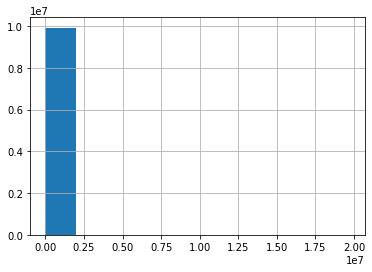

In [30]:
df['price_usd'].hist()

In [31]:
if CLIP_PRICE:
    print(f'ratio of {CLIP_PRICE}+ prices', round(len(df[df['price_usd'] > CLIP_PRICE])/len(df), 7))
    df['price_usd'] = df['price_usd'].clip(0, CLIP_PRICE)

ratio of 15000+ prices 0.0003066


In [32]:
df['subm'].value_counts()

True     4959183
False    4958347
Name: subm, dtype: int64

<AxesSubplot:>

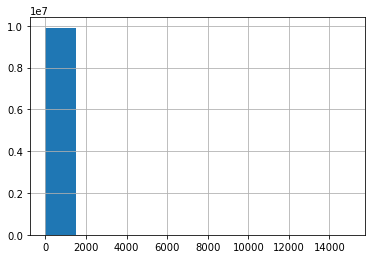

In [33]:
df['price_usd'].hist()

In [34]:
if FILTER_PRICE_SIGMA:
    # DANGEROUS to calculate statistics based on everything
    # filter outlieing prices per prop_id
    # still some outlier_prop_ids left
    mean = df.groupby(['prop_id'])['price_usd'].transform('mean')    
    std = df.groupby(['prop_id'])['price_usd'].transform('std')
    
#     subm_df = deepcopy(df[df['subm'] == True])
#     df = deepcopy(df[df['subm'] == False])
    
    # find rows and prop_id with outlieing prices compared to other prices per prop_id
    df['sigma'] = abs((df['price_usd'] - mean) / std)
    outlier_prop_ids = df[df['sigma'] > FILTER_PRICE_SIGMA]['prop_id']
    print(f"num and ratio of outlier props: {len(outlier_prop_ids)} ({round(len(outlier_prop_ids)/df['prop_id'].nunique(), 7)})")
    correct_entries = df[abs((df['price_usd'] - mean) / std) <= 2]['prop_id']
    
    # show the prices for the first property with an outlier
    display(df[df['prop_id'].isin(outlier_prop_ids.sample(1))][['prop_id', 'date_time', 'price_usd', 'sigma']].sort_values('date_time'))
    df.drop('sigma', axis=1, inplace=True)

num and ratio of outlier props: 38608 (0.2820449)


,prop_id,date_time,price_usd,sigma
962236,100060,2012-11-01 15:18:52,125.0,1.355744
3828379,100060,2012-11-03 11:59:52,99.0,0.006083
1340007,100060,2012-11-20 20:55:08,112.0,0.680914
3796140,100060,2012-11-28 15:29:06,99.0,0.006083
4056611,100060,2012-11-30 08:11:23,110.0,0.577093
...,...,...,...,...
672511,100060,2013-06-25 02:47:43,95.0,0.201557
1361649,100060,2013-06-26 05:24:24,80.0,0.980207
4387472,100060,2013-06-26 17:25:57,75.0,1.239757
2663734,100060,2013-06-27 16:55:45,100.0,0.057993


In [35]:
df['subm'].value_counts()

True     4959183
False    4958347
Name: subm, dtype: int64

if group is not in subm, if there is an outlier in a group, and the group is random, drop it

In [36]:
if FILTER_PRICE_SIGMA:
    affected_train_groups = df[(df['subm'] == False) & (df['prop_id'].isin(outlier_prop_ids)) & (df['random_bool'] == True)][group_col]
    print('ratio of affected groups', len(set(affected_train_groups)) / df[group_col].nunique())
    print('ratio of affected non submission groups', len(set(affected_train_groups)) / df[df['subm'] == False][group_col].nunique())    
    print('ratio of affected train groups', len(set(affected_train_groups)) / df[df['train'] == True][group_col].nunique())    
    print('ratio of affected non submission random groups', len(set(affected_train_groups)) / df[(df['subm'] == False) & (df['random_bool'] == True)][group_col].nunique())    
    print('ratio of affected submission groups', len(set(affected_train_groups)) / df[(df['subm'] == True)][group_col].nunique())    
    

ratio of affected groups 0.19834305550585118
ratio of affected non submission groups 0.2773993343176756
ratio of affected train groups 0.31177678395634684
ratio of affected non submission random groups 0.9122977399548978
ratio of affected submission groups 0.27774130664648783


In [37]:
df.shape

(9917530, 60)

In [38]:
df['random_bool'].value_counts()

0    6977878
1    2939652
Name: random_bool, dtype: int64

In [39]:
affected_train_groups = set(affected_train_groups.to_list())
affected_train_groups

{262144,
 1,
 131073,
 4,
 262149,
 131079,
 262151,
 11,
 12,
 131083,
 131084,
 131086,
 17,
 262167,
 131100,
 262173,
 131102,
 31,
 40,
 131113,
 131114,
 43,
 262186,
 131117,
 262191,
 262192,
 262195,
 262196,
 131127,
 56,
 131128,
 262199,
 262201,
 61,
 131133,
 63,
 262212,
 71,
 262215,
 75,
 131148,
 81,
 131153,
 83,
 262229,
 90,
 96,
 131171,
 262243,
 101,
 103,
 131178,
 107,
 108,
 110,
 131187,
 117,
 119,
 131192,
 131197,
 126,
 127,
 131198,
 131200,
 131201,
 131203,
 262272,
 133,
 134,
 131207,
 136,
 262277,
 138,
 139,
 140,
 131212,
 131214,
 262280,
 145,
 262289,
 147,
 148,
 131220,
 262291,
 262295,
 152,
 131224,
 131227,
 157,
 158,
 262301,
 160,
 161,
 131232,
 262306,
 131241,
 262314,
 131247,
 176,
 177,
 178,
 179,
 180,
 131251,
 131253,
 131256,
 187,
 262332,
 131261,
 191,
 131263,
 195,
 262340,
 131269,
 207,
 262352,
 262355,
 131284,
 213,
 131286,
 262360,
 218,
 220,
 221,
 131294,
 262366,
 131297,
 131300,
 131303,
 262377,
 236,
 2

In [40]:
df[df[group_col] == 700][[group_col, 'subm']]

,srch_id,subm
9948,700,False
9949,700,False
9950,700,False
9951,700,False
9952,700,False
9953,700,False
9954,700,False
9955,700,False
9956,700,False
9957,700,False


In [41]:
if FILTER_PRICE_SIGMA:
    df = df[~((df[group_col].isin(affected_train_groups)) & (df['subm'] == False))]
df.shape

(8526686, 60)

In [42]:
df['subm'].value_counts()

True     4959183
False    3567503
Name: subm, dtype: int64

In [43]:
df['random_bool'].value_counts()

0    6977878
1    1548808
Name: random_bool, dtype: int64

<AxesSubplot:>

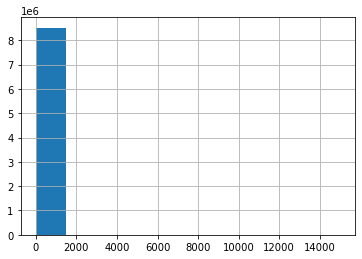

In [44]:
df['price_usd'].hist()

<AxesSubplot:>

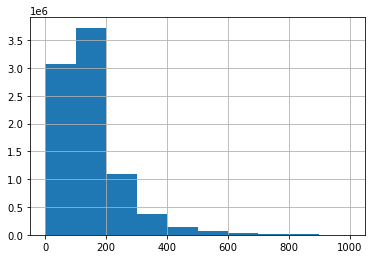

In [45]:
df[df['price_usd'] < 1000]['price_usd'].hist()

<AxesSubplot:>

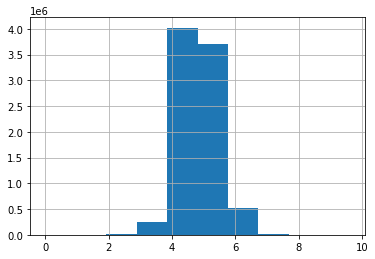

In [46]:
df['price_usd'].apply(np.log1p).hist()

In [47]:
# if FILTER_PRICE_SIGMA:
#     # show the prices for the first property after removing the outlier
# #     df[df['prop_id'].isin(outliers.values[:1])][df[df['prop_id'].isin(
# #         outliers.values[:1])]['price_usd'].index.isin(correct_entries.index)][['prop_id','price_usd']].head()

#     # calculate the mean price for properties with an outlier without the outlier
#     mean_price_per_prop_id = df[df['prop_id'].isin(outliers.values)][df[df['prop_id'].isin(outliers.values)]['price_usd'].index.isin(
#         correct_entries.index)][['prop_id','price_usd']].groupby('prop_id').mean()

#     df2 = pd.merge(df.loc[outliers.index], mean_price_per_prop_id, right_index=True, left_on = 'prop_id', how='left')
    
#     # outliers within the first prop_id 
#     # price_usd_x: original
#     # price_usd_y: after replaceing with mean
#     df2[df2['prop_id'].isin(outliers.values[:1])][['prop_id','price_usd_x', 'price_usd_y']]
    
#     # keep only price_usd_y, drop price_usd_x
#     df2 = df2.rename(columns={'price_usd_y': 'price_usd'}).drop('price_usd_x', axis=1)
    
#     # correct the outlieing prices in the original df
#     df.loc[outliers.index, 'price_usd'] = df2['price_usd']
    
# #     df['price_usd'].hist(bins=100, log=True)

#     assert df['price_usd'].isna().sum() == 0
    
#     # fill missing prices with mean
#     df['price_usd'].fillna(df['price_usd'].mean(), inplace=True)
    
#     df.loc[stats.zscore(df['price_usd']) > 3, 'price_usd'] = df['price_usd'].mean()
    
#     # filter outlieing prices overall (based on train here)
#     # the limit is around 20.000 USD, above that there is only 1 entry per price bracket -> mistake
#     df['price_usd'].hist(bins=100, log=True)
    
#     df = pd.concat([df, subm_df])

In [48]:
df['subm'].value_counts()

True     4959183
False    3567503
Name: subm, dtype: int64

# Time-independent feature engineering

## Booking time decomposition

In [49]:
df.sort_values([time_col], inplace=True)

In [50]:
if BOOKING_TIME_FEATURES:
    booking_time_prefix = 'booking_time_'

    # various time-related columns are added to the df
    time_df = get_time_features(deepcopy(df[['date_time']]), time_col='date_time',
                                prefix=booking_time_prefix,
                                within_hour_features=False,
                                hour_features=False,
                                day_features=True,
                                week_features=True,
                                month_features=True,
                                season_features=True,
                                year_features=True,)

    display(time_df.head(2))

In [51]:
enc = ce.OrdinalEncoder(cols=['date_time'])

if BOOKING_TIME_FEATURES:
    # time column is encoded as some algorithms don't work with datetime. 
    # keep both. each specific model may load needed columns
    time_df = enc.fit_transform(time_df)
else:
    time_df = enc.fit_transform(df['date_time'])

time_df.rename(columns={"date_time": "date_time_ordinal"}, inplace=True)
df = pd.concat([df, time_df], axis=1)
    
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal
485256,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,84277,4.0,3.5,0,4.72,0.3862,5.06,NaN,76.820000,1,14083,2,16,1,0,1,1,NaN,NaN,0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,False,False,False,True,76.820000,153.639999,1
485253,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,69323,3.0,4.5,0,4.70,0.1667,4.85,NaN,84.209999,0,14083,2,16,1,0,1,1,NaN,NaN,0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,1,0.0,9.0,0,0.0,30.0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,False,False,False,True,84.209999,168.419998,1
485252,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,61600,5.0,4.5,1,4.30,NaN,6.10,NaN,293.579987,0,14083,2,16,1,0,1,1,NaN,NaN,0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,False,False,False,True,293.579987,587.159973,1
485251,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,57269,4.0,4.5,0,4.62,0.1302,5.26,NaN,433.390015,1,14083,2,16,1,0,1,1,NaN,NaN,0,<NA>,NaN,NaN,<NA>,1.0,NaN,1,0.0,3.0,1,0.0,12.0,1,0.0,2.0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,False,False,False,True,433.390015,866.780029,1
485250,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,53733,3.0,3.0,0,4.49,0.1079,4.97,NaN,74.199997,0,14083,2,16,1,0,1,1,NaN,NaN,0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,0,0.0,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,False,False,False,True,74.199997,148.399994,1


In [52]:
df.shape

(8526686, 61)

### Time cyclicals

In [53]:
if BOOKING_TIME_CYCLICALS:
    max_values_dict = {
        booking_time_prefix + 'day': 31,
        booking_time_prefix + 'month': 12,
        booking_time_prefix + 'quarter': 4,
        booking_time_prefix + 'week': 52,
        booking_time_prefix + 'dow': 7,
        booking_time_prefix + 'doy': 366,
        booking_time_prefix + 'season_num': 4
    }

    cyclical = CyclicalTransformer(variables=list(max_values_dict.keys()),
                                   drop_original=False,
                                   max_values=max_values_dict)

    df = cyclical.fit_transform(df)
    df.head()

## Distance and locations

In [54]:
# df['trans_ocean'] = df['orig_destination_distance'] > 3000
# df['travel_inside'] = df['visitor_location_country_id'] == df['prop_country_id']

In [55]:
df['prop_location_score_diff'] = df['prop_location_score1'] - df['prop_location_score2']
# df['prop_location_score_diff_7'] = df['prop_location_score1'] - df['prop_location_score2'] * 7
df['prop_location_score_sum'] = df['prop_location_score1'] + df['prop_location_score2']
# df['prop_location_score_sum_7'] = df['prop_location_score1'] + df['prop_location_score2'] * 7
df['prop_location_score_mul'] = df['prop_location_score1'] * df['prop_location_score2']

In [56]:
df['prop_location_score_diff_log'] = df['prop_location_score1'] - (np.log(df['prop_location_score2'] + 1e-6) / np.log(2))
df['prop_location_score_sum_log'] = df['prop_location_score1'] + (np.log(df['prop_location_score2'] + 1e-6) / np.log(2))
df['prop_location_score_mul_log'] = df['prop_location_score1'] * (np.log(df['prop_location_score2'] + 1e-6) / np.log(2))

## Competitors

**comp1_rate** - +1 if Expedia has a lower price than competitor 1 for the hotel; 0 if the same; -1 if Expedia’s price is higher than competitor 1; null signifies there is no competitive data  

**comp1_inv** - +1 if competitor 1 does not have availability in the hotel; 0 if both Expedia and competitor 1 have availability; null signifies there is no competitive data

**comp1_rate_percent_diff** - The absolute percentage difference (if one exists) between Expedia and competitor 1’s price (Expedia’s price the denominator); null signifies there is no competitive data

In [57]:
# for i in range(1, 9):
#     print(df[df[f'comp{i}_rate'] == 0][f'comp{i}_rate_percent_diff'].value_counts(dropna=False))

In [58]:
df['higher_price_than_expedia'] = 0  # 0 to nan
df['lower_price_than_expedia'] = 0  # 0 to nan
df['same_price_as_expedia'] = 0  # 0 to nan
df['comp_num_avail'] = 0
df['comp_num_avail_nan'] = 0

for i in range(1, 9):
    df.loc[df[f'comp{i}_rate'] == 1, 'higher_price_than_expedia'] += 1
    df.loc[df[f'comp{i}_rate'] == -1, 'lower_price_than_expedia'] += 1
    df.loc[df[f'comp{i}_rate'] == 0, 'same_price_as_expedia'] += 1 
    
    df.loc[df[f'comp{i}_inv'] == 0, 'comp_num_avail'] += 1 
    df.loc[df[f'comp{i}_inv'].isna(), 'comp_num_avail_nan'] += 1 
    
df.loc[df['comp_num_avail_nan'] == 8, 'comp_num_avail'] = np.nan
df.drop(['comp_num_avail_nan'], axis=1, inplace=True)

df['higher_price_than_expedia'].replace(0, np.nan, inplace=True)
df['lower_price_than_expedia'].replace(0, np.nan, inplace=True)
df['same_price_as_expedia'].replace(0, np.nan, inplace=True)

df['ratio_of_comp_with_higher_price_than_expedia'] = df['higher_price_than_expedia'] / df['comp_num_avail']
df['ratio_of_comp_with_lower_price_than_expedia'] = df['lower_price_than_expedia'] / df['comp_num_avail']

In [59]:
if COMP_RATE_PERCENT_DIFF_SIGNED_FEATURES:
    for i in range(1, 9):
        df[f'comp{i}_rate_percent_diff_signed'] = df[f'comp{i}_rate'] * df[f'comp{i}_rate_percent_diff']
        df.drop([f'comp{i}_rate'], axis=1, inplace=True)

In [60]:
# if COMP_RATE_PERCENT_DIFF_TRANSFORMATION_FEATURES:
#     df = num_transformations(df,
#                          [f'comp{i}_rate_percent_diff' for i in range(1, 9)],
#                          powers=[],
#                          log_bases=[2, 10], 
#                          do_reciprocal=False,
#                          do_exp=False)
# else:
#     for i in range(1, 9):
#         df.drop([f'comp{i}_rate_percent_diff'], axis=1, inplace=True)  # bcs it's just a sign for the new feature

In [61]:
df.shape

(8526686, 73)

In [62]:
df.drop([
    'comp1_inv',
    'comp1_rate_percent_diff',
    'comp2_inv',
    'comp2_rate_percent_diff',
    'comp3_inv',
#     'comp3_rate_percent_diff',
    'comp4_inv',
    'comp4_rate_percent_diff',
    'comp5_inv',
    'comp5_rate_percent_diff',
    'comp6_inv',
    'comp6_rate_percent_diff',
    'comp7_inv',
    'comp7_rate_percent_diff',
    'comp8_inv',
    'comp8_rate_percent_diff',
    'higher_price_than_expedia',
    'lower_price_than_expedia',
    'same_price_as_expedia',
    'comp_num_avail',
    'ratio_of_comp_with_higher_price_than_expedia',
    'comp1_rate_percent_diff_signed',
    'comp2_rate_percent_diff_signed',
    'comp3_rate_percent_diff_signed',
    'comp4_rate_percent_diff_signed',
    'comp6_rate_percent_diff_signed',
    'comp7_rate_percent_diff_signed',
],
        axis=1,
        inplace=True)

In [63]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp3_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed
485256,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,84277,4.0,3.5,0,4.72,0.3862,5.06,NaN,76.820000,1,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,76.820000,153.639999,1,4.3338,5.1062,1.822864,6.092576,3.347424,-6.478559,NaN,<NA>,<NA>
485253,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,69323,3.0,4.5,0,4.70,0.1667,4.85,NaN,84.209999,0,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,84.209999,168.419998,1,4.5333,4.8667,0.783490,7.284665,2.115335,-12.147926,NaN,0.0,<NA>
485252,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,61600,5.0,4.5,1,4.30,NaN,6.10,NaN,293.579987,0,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,293.579987,587.159973,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>
485251,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,57269,4.0,4.5,0,4.62,0.1302,5.26,NaN,433.390015,1,14083,2,16,1,0,1,1,NaN,NaN,0,3.0,NaN,NaN,NaN,False,False,False,True,433.390015,866.780029,1,4.4898,4.7502,0.601524,7.561187,1.678812,-13.588286,NaN,2.0,<NA>
485250,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,53733,3.0,3.0,0,4.49,0.1079,4.97,NaN,74.199997,0,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,74.199997,148.399994,1,4.3821,4.5979,0.484471,7.702220,1.277780,-14.422866,NaN,NaN,<NA>


In [64]:
df.shape

(8526686, 47)

## Money features

### Money transformations

In [65]:
df = num_transformations(df,
                         [
#                              'price_usd', 
                          'price_per_day'],
                         powers=[2, 3],
                         log_bases=[10])

In [66]:
# df = num_transformations(df,
#                          [
# #                              'visitor_hist_adr_usd',
# #                           'price_per_trip'
#                          ],
#                          powers=[0.33, 0.5, 2, 3],
#                          log_bases=[2, 10, round(np.e, 2)])

In [67]:
df = num_transformations(df, ['prop_log_historical_price'],
                         powers=[0.33],
                         log_bases=[10],
                         do_exp=False)

**prop_log_historical_price** - The logarithm of the mean price of the hotel over the last trading period. A 0 will occur if the hotel was not sold in that period.  

In [68]:
df['prop_historical_price'] = np.exp(df['prop_log_historical_price'])

**visitor_hist_adr_usd** - The mean price per night (in US$) of the hotels the customer has previously purchased; null signifies there is no purchase history on the customer  

**price_usd** - Displayed price of the hotel for the given search.  Note that different countries have different conventions regarding displaying taxes and fees and the value may be per night or for the whole stay

In [69]:
df['price_diff_to_usr_hist'] = df['price_usd'] - df['visitor_hist_adr_usd']
df['price_ratio_to_usr_hist'] = df['price_usd'] / (df['visitor_hist_adr_usd'] + 1e-2)

df['price_per_day_diff_to_usr_hist'] = df['price_per_day'] - df['visitor_hist_adr_usd']
df['price_per_day_ratio_to_usr_hist'] = df['price_per_day'] / (df['visitor_hist_adr_usd'] + 1e-2)

df['price_per_trip_diff_to_usr_hist'] = df['price_per_trip'] - df['visitor_hist_adr_usd']
df['price_per_trip_ratio_to_usr_hist'] = df['price_per_trip'] / (df['visitor_hist_adr_usd'] + 1e-2)

df['price_diff_to_place_hist_price'] = df['price_usd'] - np.exp(df['prop_log_historical_price'])
df['price_per_day_diff_to_place_hist_price'] = df['price_per_day'] - np.exp(df['prop_log_historical_price'])
df['price_per_trip_diff_to_place_hist_price'] = df['price_per_trip'] - np.exp(df['prop_log_historical_price'])
df['place_hist_price_diff_usr_hist'] = np.exp(df['prop_log_historical_price']) - df['visitor_hist_adr_usd']

In [70]:
# totally missed in submission df
# df['usr_extra_pay'] = df['gross_bookings_usd'] - df['price_usd']

## Stars

**visitor_hist_starrating** - The mean star rating of hotels the customer has previously purchased; null signifies there is no purchase history on the customer

**prop_starrating** - The star rating of the hotel, from 1 to 5, in increments of 1.  A 0 indicates the property has no stars, the star rating is not known or cannot be publicized.

**prop_review_score** - The mean customer review score for the hotel on a scale out of 5, rounded to 0.5 increments. A 0 means there have been no reviews, null that the information is not available.

In [71]:
df['prop_star_usr_hist_diff'] = df['prop_starrating'] - df['visitor_hist_starrating']
df['prop_review_usr_hist_diff'] = df['prop_review_score'] - df['visitor_hist_starrating']

df['prop_starrating_bonus_chain'] = df['prop_starrating'] + df['prop_brand_bool']

In [72]:
df['prop_star_review_sum'] = df['prop_starrating'] + df['prop_review_score']
df['prop_star_review_diff'] = df['prop_starrating'] - df['prop_review_score']
df['prop_star_review_min'] = df[['prop_starrating', 'prop_review_score']].parallel_apply(min, axis=1)
df['prop_star_review_max'] = df[['prop_starrating', 'prop_review_score']].parallel_apply(max, axis=1)
df['prop_star_review_mean'] = df[['prop_starrating', 'prop_review_score']].parallel_apply(np.mean, axis=1)

### Price\star

In [73]:
df['price_per_star'] = df['price_per_day'] / (df['prop_starrating'] + 1e-6)
df['price_per_review_score'] = df['price_per_day'] / (df['prop_review_score'] + 1e-6)

# df['usr_price_per_star'] = df['visitor_hist_adr_usd'] / df['visitor_hist_starrating']

# df['price_per_star_diff_with_usr'] = df['price_per_star'] - df['usr_price_per_star']
# df['price_per_review_diff_with_usr'] = df['price_per_review_score'] - df['usr_price_per_star']

In [74]:
df = num_transformations(df,
                         ['price_per_star', 'price_per_review_score', 
#                           'usr_price_per_star'
                         ],
                         powers=[],
                         log_bases=[10], 
                         do_reciprocal=False,
                         do_exp=False)

In [75]:
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp3_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10
485256,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,84277,4.0,3.5,0,4.72,0.3862,5.06,NaN,76.820000,1,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,76.820000,153.639999,1,4.3338,5.1062,1.822864,6.092576,3.347424,-6.478559,NaN,<NA>,<NA>,5901.31250,1.885474,0.013017,1.707535,0.704151,0.197628,157.590500,NaN,NaN,NaN,NaN,NaN,NaN,-80.770500,-80.770500,-3.950500,NaN,NaN,NaN,4.0,7.5,0.5,3.5,4.0,3.75,19.204995,21.948565,1.283414,1.341406
485253,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,69323,3.0,4.5,0,4.70,0.1667,4.85,NaN,84.209999,0,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,84.209999,168.419998,1,4.5333,4.8667,0.783490,7.284665,2.115335,-12.147926,NaN,0.0,<NA>,7091.32373,1.925364,0.011875,1.683817,0.685742,0.206186,127.740387,NaN,NaN,NaN,NaN,NaN,NaN,-43.530388,-43.530388,40.679611,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,28.069990,18.713329,1.448242,1.272151


In [76]:
df.shape

(8526686, 76)

## Days of staying

**srch_length_of_stay** - Number of nights stay that was searched


**srch_booking_window** - Number of days in the future the hotel stay started from the search date

In [77]:
df['booking_weeks_ahead'] = df['srch_booking_window'] / 7
# df['booking_months_ahead'] = df['srch_booking_window'] / 30

df['len_of_stay_to_booking_ahead_ratio'] = df['srch_booking_window'] / df['srch_length_of_stay']
# df['len_of_stay_to_booking_ahead_diff'] = df['srch_booking_window'] - df['srch_length_of_stay']

In [78]:
# df['srch_length_of_stay_in_weeks'] = df['srch_length_of_stay'] // 7
# df['srch_length_of_stay_in_weeks'].value_counts()

### Calculate date of trip
from: date_time + srch_booking_window\
until: date_time + srch_booking_window + srch_length_of_stay

In [79]:
df['date'] = df['date_time'].dt.floor('D')
df['days_until_trip'] = pd.to_timedelta(df['srch_booking_window'], unit='D')

df['trip_start_date'] = df['date'] + df['days_until_trip']
df['trip_end_date'] = df['date'] + df['days_until_trip'] + pd.to_timedelta(df['srch_length_of_stay'], unit='D')

df.drop(['days_until_trip'], axis=1, inplace=True)

In [80]:
trip_start = get_time_features(deepcopy(df[['trip_start_date']]), time_col='trip_start_date', 
                               prefix='trip_start_date_', 
                               within_hour_features=False, hour_features=False,
                               day_features=False, week_features=True, month_features=True, 
                               season_features=True, year_features=True)
trip_start.drop('trip_start_date', axis=1, inplace=True)
# trip_start.drop([c for c in trip_start.columns if 'week' not in c], axis=1, inplace=True)
trip_start.head(2)

,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id
485256,46,8,11,30,4,4,2012,201246
485253,46,8,11,30,4,4,2012,201246


In [81]:
trip_end = get_time_features(deepcopy(df[['trip_end_date']]), time_col='trip_end_date', 
                               prefix='trip_end_date_', 
                               within_hour_features=False, hour_features=False,
                               day_features=False, week_features=True, month_features=True, 
                               season_features=True, year_features=True)
trip_end.drop('trip_end_date', axis=1, inplace=True)
# trip_end.drop([c for c in trip_end.columns if 'week' not in c], axis=1, inplace=True)
trip_end.head(2)

,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id
485256,47,7,11,30,4,4,2012,201247
485253,47,7,11,30,4,4,2012,201247


In [82]:
df = pd.concat([df, trip_start, trip_end], axis=1)

In [83]:
df.shape

(8526686, 97)

### Count holidays (work free day) during the trip

In [84]:
if HOLIDAY_DURING_TRIP_FEATURE:
    cal = calendar()
    # holidays = cal.holidays(start=min(df['trip_start_date']), end=max(df['trip_end_date']))

    holidays = cal.holidays(start=min(df['trip_start_date']), end=max(df['trip_end_date']), return_name=True)
   
    df['holidays_during_trip'] = np.nan
    # for holiday in holidays:
    #     df['holidays_during_trip'] += (df['trip_start_date'] <= holiday) & (df['trip_end_date'] >= holiday)

    for holiday in holidays.items():
        print(holiday[0], holiday[1])
        df.loc[(df['trip_start_date'] <= holiday[0]) & (df['trip_end_date'] >= holiday[0]), 'holiday_during_trip'] = holiday[1]

In [85]:
if HOLIDAY_DURING_TRIP_FEATURE:
    df['holiday_during_trip'].value_counts(dropna=False)

add some number of days before and after. weight them

### Holidays during the day of booking

In [86]:
if HOLIDAY_DURING_BOOKING_FEATURE:
    df['holiday_during_booking'] = np.nan

    for holiday in holidays.items():
        print(holiday[0], holiday[1])
        df.loc[(df['date'] == holiday[0]), 'holiday_during_booking'] = holiday[1]        

In [87]:
if HOLIDAY_DURING_BOOKING_FEATURE:
    df['holiday_during_booking'].value_counts(dropna=False)

### Try to separate business trips from holidays

sign for worktrip:\
srch_children_count = 0\
srch_adults_count = 1\
srch_saturday_night_bool = False\
srch_length_of_stay < avg\
orig_destination_distance < avg\
srch_booking_window < avg

In [88]:
# df['business_trip'] = False
# df.loc[(df['srch_children_count'] == 0) & (df['srch_adults_count'] == 1) &
#        (~df['srch_saturday_night_bool']) & (df['srch_length_of_stay'] <= 5), 'business_trip'] = True

## Family

**srch_adults_count** - The number of adults specified in the hotel room

 
**srch_children_count** - The number of (extra occupancy) children specified in the hotel room

 
**srch_room_count** - Number of hotel rooms specified in the search

In [89]:
df['children_per_adult'] = df['srch_children_count'] / df['srch_adults_count']
df['total_people'] = df['srch_children_count'] + df['srch_adults_count']
df['people_per_room'] = df['total_people'] / df['srch_room_count']

df['separate_children_room'] = df['srch_children_count'] & (df['srch_room_count'] > 1)

## Normalize

In [90]:
from features import normalize_features

In [91]:
df[df['price_usd'] < 0]['price_usd']

Series([], Name: price_usd, dtype: float32)

In [92]:
df = normalize_features(df, group_key="srch_id", 
                        target_column="price_usd",
                        take_log10=True,
                       )
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp3_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id
0,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,84277,4.0,3.5,0,4.72,0.3862,5.06,NaN,76.820000,1,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,76.820000,153.639999,1,4.3338,5.1062,1.822864,6.092576,3.347424,-6.478559,NaN,<NA>,<NA>,5901.31250,1.885474,0.013017,1.707535,0.704151,0.197628,157.590500,NaN,NaN,NaN,NaN,NaN,NaN,-80.770500,-80.770500,-3.950500,NaN,NaN,NaN,4.0,7.5,0.5,3.5,4.0,3.75,19.204995,21.948565,1.283414,1.341406,2.285714,8.0,2012-11-01,2012-11-17,2012-11-19,46,8,11,30,4,4,2012,201246,47,7,11,30,4,4,2012,201247,0.0,1,1.0,False,-0.824531
1,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,69323,3.0,4.5,0,4.70,0.1667,4.85,NaN,84.209999,0,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,84.209999,168.419998,1,4.5333,4.8667,0.783490,7.284665,2.115335,-12.147926,NaN,0.0,<NA>,7091.32373,1.925364,0.011875,1.683817,0.685742,0.206186,127.740387,NaN,NaN,NaN,NaN,NaN,NaN,-43.530388,-43.530388,40.679611,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,28.069990,18.713329,1.448242,1.272151,2.285714,8.0,2012-11-01,2012-11-17,2012-11-19,46,8,11,30,4,4,2012,201246,47,7,11,30,4,4,2012,201247,0.0,1,1.0,False,-0.671271


In [93]:
df['price_usd_log10_norm_by_srch_id'].isna().mean()

0.00010777927086795503

In [94]:
df = normalize_features(df, group_key="prop_id", 
                        target_column="price_usd",
                        take_log10=True,
                       )
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp3_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id
0,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,84277,4.0,3.5,0,4.72,0.3862,5.06,NaN,76.82,1,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,76.82,153.639999,1,4.3338,5.1062,1.822864,6.092576,3.347424,-6.478559,NaN,<NA>,<NA>,5901.3125,1.885474,0.013017,1.707535,0.704151,0.197628,157.5905,NaN,NaN,NaN,NaN,NaN,NaN,-80.7705,-80.7705,-3.9505,NaN,NaN,NaN,4.0,7.5,0.5,3.5,4.0,3.75,19.204995,21.948565,1.283414,1.341406,2.285714,8.0,2012-11-01,2012-11-17,2012-11-19,46,8,11,30,4,4,2012,201246,47,7,11,30,4,4,2012,201247,0.0,1,1.0,False,-0.824531,-0.245700
1,206851,2012-11-02 09:17:45,26,39,NaN,NaN,225,84277,4.0,3.5,0,4.72,0.1324,5.06,NaN,76.75,1,11308,4,22,2,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,76.75,307.000000,1516,4.5876,4.8524,0.624928,7.637014,1.802986,-13.768306,NaN,<NA>,<NA>,5890.5625,1.885078,0.013029,1.707535,0.704151,0.197628,157.5905,NaN,NaN,NaN,NaN,NaN,NaN,-80.8405,-80.8405,149.4095,NaN,NaN,NaN,4.0,7.5,0.5,3.5,4.0,3.75,19.187495,21.928565,1.283018,1.341010,3.142857,5.5,2012-11-02,2012-11-24,2012-11-28,47,7,11,30,4,4,2012,201247,48,6,11,30,4,4,2012,201248,0.0,2,2.0,False,-1.415146,-0.252332


In [95]:
df['price_usd_log10_norm_by_prop_id'].isna().mean()

0.001510317138452149

In [96]:
df = normalize_features(df, group_key="srch_id", 
                        target_column="prop_starrating")
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp3_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_per_day_diff_to_usr_hist,price_per_day_ratio_to_usr_hist,price_per_trip_diff_to_usr_hist,price_per_trip_ratio_to_usr_hist,price_diff_to_place_hist_price,price_per_day_diff_to_place_hist_price,price_per_trip_diff_to_place_hist_price,place_hist_price_diff_usr_hist,prop_star_usr_hist_diff,prop_review_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date,trip_end_date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_days_in_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_days_in_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id,prop_starrating_norm_by_srch_id
0,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,84277,4.0,3.5,0,4.72,0.3862,5.06,NaN,76.820000,1,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,76.820000,153.639999,1,4.3338,5.1062,1.822864,6.092576,3.347424,-6.478559,NaN,<NA>,<NA>,5901.31250,1.885474,0.013017,1.707535,0.704151,0.197628,157.590500,NaN,NaN,NaN,NaN,NaN,NaN,-80.770500,-80.770500,-3.950500,NaN,NaN,NaN,4.0,7.5,0.5,3.5,4.0,3.75,19.204995,21.948565,1.283414,1.341406,2.285714,8.0,2012-11-01,2012-11-17,2012-11-19,46,8,11,30,4,4,2012,201246,47,7,11,30,4,4,2012,201247,0.0,1,1.0,False,-0.824531,-0.245700,0.568731
1,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,69323,3.0,4.5,0,4.70,0.1667,4.85,NaN,84.209999,0,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,84.209999,168.419998,1,4.5333,4.8667,0.783490,7.284665,2.115335,-12.147926,NaN,0.0,<NA>,7091.32373,1.925364,0.011875,1.683817,0.685742,0.206186,127.740387,NaN,NaN,NaN,NaN,NaN,NaN,-43.530388,-43.530388,40.679611,NaN,NaN,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,28.069990,18.713329,1.448242,1.272151,2.285714,8.0,2012-11-01,2012-11-17,2012-11-19,46,8,11,30,4,4,2012,201246,47,7,11,30,4,4,2012,201247,0.0,1,1.0,False,-0.671271,-1.183756,-0.731226


In [97]:
df['prop_starrating_norm_by_srch_id'].isna().mean()

0.04410752313384121

In [98]:
df.shape

(8526686, 104)

In [99]:
# some of the columns commented in features_dict
df.drop([
    'trip_end_date_days_in_month',
    'trip_start_date_days_in_month',
    'trip_start_date',
    'trip_end_date',
    'prop_review_usr_hist_diff',
    'place_hist_price_diff_usr_hist',
    'prop_review_usr_hist_diff',
    'price_per_day_diff_to_place_hist_price',
    'price_per_trip_diff_to_place_hist_price',
    'price_per_trip_ratio_to_usr_hist',
    'price_per_trip_diff_to_usr_hist',
    'price_per_day_ratio_to_usr_hist',
    'price_per_day_diff_to_usr_hist'
],
        axis=1,
        inplace=True)

In [100]:
df.shape

(8526686, 92)

## Order price per category and add position per category 

TODO:\
add price per prop_id and month/season\
add price per destination_id and month/season

totally safe as we always have srch_id granularity

In [101]:
# Order price per srch_id 
df.sort_values(['srch_id', 'price_usd'], inplace=True)
df['price_index_per_srch_id'] = df.groupby(['srch_id']).cumcount()
df.sort_index(inplace=True)
df[df['srch_id'] == 4][['price_usd', 'price_index_per_srch_id']].sort_values('price_usd').head(10)

,price_usd,price_index_per_srch_id


TODO: check if not leaky

In [102]:
# Order price per srch_destination_id 
df.sort_values(['srch_destination_id', 'price_usd'], inplace=True)
df['price_index_per_srch_destination_id'] = df.groupby(['srch_destination_id']).cumcount()
df.sort_index(inplace=True)

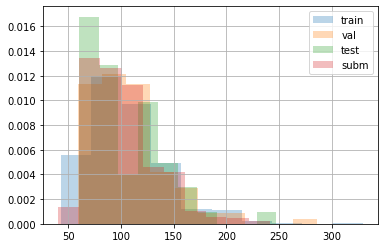

In [103]:
df.loc[df['train'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3, label='train')
df.loc[df['val'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3, label='val')
df.loc[df['test'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3, label='test')
df.loc[df['subm'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3, label='subm')
# df.loc[df['subm'] & (df['srch_destination_id'] == 11197), 'price_usd'].hist(density=True, alpha=0.3)
plt.legend();

the hists are not perfectly the same but price is known in advance in this competition. 

this is tricky. but if we know the price in advance, why not

In [104]:
# Order price per prop_id 
df.sort_values(['prop_id', 'price_usd'], inplace=True)
df['price_index_per_prop_id'] = df.groupby(['prop_id']).cumcount()
df.sort_index(inplace=True)

## Others

**srch_query_affinity_score** - The log of the probability a hotel will be clicked on in Internet searches (hence the values are negative)  A null signifies there are no data (i.e. hotel did not register in any searches)

In [105]:
df['srch_query_affinity_score_prob'] = np.exp(df['srch_query_affinity_score'])

# Feature engineering with respect to the time 

## prop_starrating_monotonic (feature from winner)

In [106]:
# mean_booking_starrating = df[df['train'] & df['booking_bool']]['prop_starrating'].mean()
# print(mean_booking_starrating)

# df['prop_starrating_monotonic'] = abs(df['prop_starrating'] - mean_booking_starrating) 
# df['prop_starrating_monotonic'].hist();

## Booking and clicking probs during train

In [107]:
book_click_prob_per_prop = df[df['train']].groupby(['prop_id'])[['booking_bool', 'click_bool']].mean()
book_click_prob_per_prop.rename(columns={'booking_bool': 'booking_prob_train',
                                         'click_bool': 'click_prob_train'}, inplace=True)
book_click_prob_per_prop

,booking_prob_train,click_prob_train
prop_id,,
1,0.000000,0.000000
2,0.100000,0.100000
3,0.033333,0.033333
4,0.100000,0.100000
5,0.000000,0.000000
...,...,...
140816,0.117647,0.125000
140817,0.000000,0.000000
140818,0.000000,0.000000


In [108]:
book_click_prob_per_prop['book_per_click'] = book_click_prob_per_prop['booking_prob_train'] / \
    book_click_prob_per_prop['click_prob_train']  # 0/0 will be replaced with nans which is ok

In [109]:
df = pd.merge(df, book_click_prob_per_prop.reset_index(), on='prop_id',
              how='left')
df.shape

(8526686, 99)

In [110]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp3_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_diff_to_place_hist_price,prop_star_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id,prop_starrating_norm_by_srch_id,price_index_per_srch_id,price_index_per_srch_destination_id,price_index_per_prop_id,srch_query_affinity_score_prob,booking_prob_train,click_prob_train,book_per_click
0,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,84277,4.0,3.5,0,4.72,0.3862,5.06,NaN,76.820000,1,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,76.820000,153.639999,1,4.3338,5.1062,1.822864,6.092576,3.347424,-6.478559,NaN,<NA>,<NA>,5901.312500,1.885474,0.013017,1.707535,0.704151,0.197628,157.590500,NaN,NaN,-80.770500,NaN,4.0,7.5,0.5,3.5,4.0,3.75,19.204995,21.948565,1.283414,1.341406,2.285714,8.0,2012-11-01,46,8,11,4,4,2012,201246,47,7,11,4,4,2012,201247,0.0,1,1.0,False,-0.824531,-0.245700,0.568731,8,151,56,NaN,0.105263,0.157895,0.666667
1,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,69323,3.0,4.5,0,4.70,0.1667,4.85,NaN,84.209999,0,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,84.209999,168.419998,1,4.5333,4.8667,0.783490,7.284665,2.115335,-12.147926,NaN,0.0,<NA>,7091.323730,1.925364,0.011875,1.683817,0.685742,0.206186,127.740387,NaN,NaN,-43.530388,NaN,3.0,7.5,-1.5,3.0,4.5,3.75,28.069990,18.713329,1.448242,1.272151,2.285714,8.0,2012-11-01,46,8,11,4,4,2012,201246,47,7,11,4,4,2012,201247,0.0,1,1.0,False,-0.671271,-1.183756,-0.731226,14,277,0,NaN,0.000000,0.000000,NaN
2,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,61600,5.0,4.5,1,4.30,NaN,6.10,NaN,293.579987,0,14083,2,16,1,0,1,1,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,True,293.579987,587.159973,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,86189.210938,2.467726,0.003406,1.816180,0.785330,0.163934,445.857697,NaN,NaN,-152.277710,NaN,6.0,9.5,0.5,4.5,5.0,4.75,58.715986,65.239983,1.768756,1.814514,2.285714,8.0,2012-11-01,46,8,11,4,4,2012,201246,47,7,11,4,4,2012,201247,0.0,1,1.0,False,1.412668,-0.467286,1.868688,46,1329,27,NaN,0.023810,0.023810,1.000000
3,32491,2012-11-01 00:01:37,24,216,NaN,NaN,225,57269,4.0,4.5,0,4.62,0.1302,5.26,NaN,433.390015,1,14083,2,16,1,0,1,1,NaN,NaN,0,3.0,NaN,NaN,NaN,False,False,False,True,433.390015,866.780029,1,4.4898,4.7502,0.6015

## Position during train

In [111]:
position_per_prop = df[df['train']].groupby(['prop_id'])[['position']].mean()
position_per_prop.rename(columns={'position': 'mean_position_train'}, inplace=True)
position_per_prop

,mean_position_train
prop_id,
1,30.068182
2,16.400000
3,19.966667
4,18.500000
5,23.818182
...,...
140816,18.970588
140817,8.000000
140818,25.000000


In [112]:
position_no_random_per_prop = df[df['train'] & (~df['random_bool'])].groupby(['prop_id'])[['position']].mean()
position_no_random_per_prop.rename(columns={'position': 'mean_position_train_when_not_random'}, inplace=True)
position_no_random_per_prop

,mean_position_train_when_not_random
prop_id,
1,30.785714
2,16.400000
3,19.966667
4,17.333333
5,23.818182
...,...
140816,18.970588
140817,8.000000
140818,25.000000


In [113]:
df = pd.merge(df, pd.concat([position_per_prop, position_no_random_per_prop], axis=1).reset_index(), 
              on='prop_id',
              how='left')
df.shape

(8526686, 101)

## Aggregations

In [114]:
from features import apply_composite_for_splits

### Price aggregations

#### srch_id

In [115]:
# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'prop_starrating'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,  # srch_id is independent on split
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

257103 groups when aggregation by ['srch_id']


(8526686, 113)

In [116]:
# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'prop_location_score2'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

257103 groups when aggregation by ['srch_id']


(8526686, 125)

In [117]:
# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'prop_location_score1'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

257103 groups when aggregation by ['srch_id']


(8526686, 137)

In [118]:
# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'price_usd'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

257103 groups when aggregation by ['srch_id']


(8526686, 149)

In [119]:
# prices from the country of user for the destination country
groupby_cols = ['srch_id']
feature_value_col = 'prop_review_score'
agg_methods = ["mean", "min", "max"]

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods)
df.shape

257103 groups when aggregation by ['srch_id']


(8526686, 158)

In [120]:
# df.drop(['mean_promotion_flag_per_srch_id', 
#          'promotion_flag_diff_to_mean_promotion_flag_per_srch_id'
#         ], axis=1, inplace=True)


# df = df.join(df.groupby('srch_id')['promotion_flag'].mean().rename('mean_promotion_flag_per_srch_id'), 
#              on='srch_id', how='left')
# df['promotion_flag_diff_to_mean_promotion_flag_per_srch_id'] = df['promotion_flag'] - df['mean_promotion_flag_per_srch_id']


In [121]:
groupby_cols = ['srch_id']
feature_value_col = 'promotion_flag'
agg_methods = ["mean"]

df['promotion_flag'] = df['promotion_flag'].astype('uint8')

df = apply_composite_for_splits(df, 
                                split_cols=None,
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=agg_methods,
                                relative_diff=False)
df.shape

257103 groups when aggregation by ['srch_id']


(8526686, 160)

In [122]:
df[df['promotion_flag'] == 1][['promotion_flag', 'mean_promotion_flag_per_srch_id',
                               'promotion_flag_diff_to_mean_promotion_flag_per_srch_id']]

,promotion_flag,mean_promotion_flag_per_srch_id,promotion_flag_diff_to_mean_promotion_flag_per_srch_id
0,1,0.294118,0.705882
3,1,0.294118,0.705882
5,1,0.294118,0.705882
6,1,0.294118,0.705882
7,1,0.294118,0.705882
...,...,...,...
8526604,1,0.200000,0.800000
8526627,1,0.111111,0.888889
8526640,1,0.285714,0.714286
8526643,1,0.285714,0.714286


In [123]:
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp3_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_diff_to_place_hist_price,prop_star_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id,prop_starrating_norm_by_srch_id,price_index_per_srch_id,price_index_per_srch_destination_id,price_index_per_prop_id,srch_query_affinity_score_prob,booking_prob_train,click_prob_train,book_per_click,mean_position_train,mean_position_train_when_not_random,mean_prop_starrating_per_srch_id,median_prop_starrating_per_srch_id,min_prop_starrating_per_srch_id,max_prop_starrating_per_srch_id,prop_starrating_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_diff_to_median_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_median_prop_starrating_per_srch_id,prop_starrating_diff_to_min_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_min_prop_starrating_per_srch_id,prop_starrating_diff_to_max_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_max_prop_starrating_per_srch_id,mean_prop_location_score2_per_srch_id,median_prop_location_score2_per_srch_id,min_prop_location_score2_per_srch_id,max_prop_location_score2_per_srch_id,prop_location_score2_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_diff_to_max_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_max_prop_location_score2_per_srch_id,mean_prop_location_score1_per_srch_id,median_prop_location_score1_per_srch_id,min_prop_location_score1_per_srch_id,max_prop_location_score1_per_srch_id,prop_location_score1_diff_to_mean_prop_location_score1_per_srch_id,prop_location_score1_rel_diff_to_mean_prop_location_score1_per_srch_id,prop_location_score1_diff_to_median_prop_location_score1_per_srch_id,prop_location_score1_rel_diff_to_median_prop_location_score1_per_srch_id,prop_location_score1_diff_to_min_prop_location_score1_per_srch_id,prop_loc

#### prop_country_id

In [124]:
df.shape

(8526686, 160)

In [125]:
# was removed. return back
# prices for the hotel country
groupby_cols = ['prop_country_id']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["min", "max"])

# # prices for the hotel country for the season of trip for specific number of rooms
# groupby_cols = ['prop_country_id', 'srch_room_count', 'trip_start_date_quarter']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])

172 groups when aggregation by ['prop_country_id']
118 groups when aggregation by ['prop_country_id']
132 groups when aggregation by ['prop_country_id']
167 groups when aggregation by ['prop_country_id']


In [126]:
# prices from the country of user for the destination country
groupby_cols = ['visitor_location_country_id', 'prop_country_id']
feature_value_col = 'price_per_day'
agg_methods = ["mean", "median", "min", "max"]

df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

3399 groups when aggregation by ['visitor_location_country_id', 'prop_country_id']


/Users/Oleg_Litvinov1/Documents/Code/Expedia_HTTPS/features.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[feature_value_col + '_rel_diff_to_' + new_feature_name] = (input_df[feature_value_col] - input_df[


812 groups when aggregation by ['visitor_location_country_id', 'prop_country_id']
872 groups when aggregation by ['visitor_location_country_id', 'prop_country_id']
4001 groups when aggregation by ['visitor_location_country_id', 'prop_country_id']


(8526686, 178)

In [127]:
# prices from the country of user for the destination country for the season of trip
groupby_cols = ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

6698 groups when aggregation by ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']


/Users/Oleg_Litvinov1/Documents/Code/Expedia_HTTPS/features.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[feature_value_col + '_diff_to_' + new_feature_name] = input_df[feature_value_col] - input_df[


1303 groups when aggregation by ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']
1437 groups when aggregation by ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']
8233 groups when aggregation by ['visitor_location_country_id', 'prop_country_id', 'trip_start_date_quarter']


(8526686, 190)

In [128]:
# 

# # prices for the hotel country for the season of trip
# groupby_cols = ['prop_country_id', 'trip_start_date_quarter']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])

In [129]:
df.head(2)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp3_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool,test,val,train,subm,price_per_day,price_per_trip,date_time_ordinal,prop_location_score_diff,prop_location_score_sum,prop_location_score_mul,prop_location_score_diff_log,prop_location_score_sum_log,prop_location_score_mul_log,ratio_of_comp_with_lower_price_than_expedia,comp5_rate_percent_diff_signed,comp8_rate_percent_diff_signed,price_per_day_pow_2,price_per_day_log_10,price_per_day_reciprocal,prop_log_historical_price_pow_0.33,prop_log_historical_price_log_10,prop_log_historical_price_reciprocal,prop_historical_price,price_diff_to_usr_hist,price_ratio_to_usr_hist,price_diff_to_place_hist_price,prop_star_usr_hist_diff,prop_starrating_bonus_chain,prop_star_review_sum,prop_star_review_diff,prop_star_review_min,prop_star_review_max,prop_star_review_mean,price_per_star,price_per_review_score,price_per_star_log_10,price_per_review_score_log_10,booking_weeks_ahead,len_of_stay_to_booking_ahead_ratio,date,trip_start_date_week,trip_start_date_week_mid_summer_index,trip_start_date_month,trip_start_date_quarter,trip_start_date_season_num,trip_start_date_year,trip_start_date_week_id,trip_end_date_week,trip_end_date_week_mid_summer_index,trip_end_date_month,trip_end_date_quarter,trip_end_date_season_num,trip_end_date_year,trip_end_date_week_id,children_per_adult,total_people,people_per_room,separate_children_room,price_usd_log10_norm_by_srch_id,price_usd_log10_norm_by_prop_id,prop_starrating_norm_by_srch_id,price_index_per_srch_id,price_index_per_srch_destination_id,price_index_per_prop_id,srch_query_affinity_score_prob,booking_prob_train,click_prob_train,book_per_click,mean_position_train,mean_position_train_when_not_random,mean_prop_starrating_per_srch_id,median_prop_starrating_per_srch_id,min_prop_starrating_per_srch_id,max_prop_starrating_per_srch_id,prop_starrating_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_mean_prop_starrating_per_srch_id,prop_starrating_diff_to_median_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_median_prop_starrating_per_srch_id,prop_starrating_diff_to_min_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_min_prop_starrating_per_srch_id,prop_starrating_diff_to_max_prop_starrating_per_srch_id,prop_starrating_rel_diff_to_max_prop_starrating_per_srch_id,mean_prop_location_score2_per_srch_id,median_prop_location_score2_per_srch_id,min_prop_location_score2_per_srch_id,max_prop_location_score2_per_srch_id,prop_location_score2_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_mean_prop_location_score2_per_srch_id,prop_location_score2_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_median_prop_location_score2_per_srch_id,prop_location_score2_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_min_prop_location_score2_per_srch_id,prop_location_score2_diff_to_max_prop_location_score2_per_srch_id,prop_location_score2_rel_diff_to_max_prop_location_score2_per_srch_id,mean_prop_location_score1_per_srch_id,median_prop_location_score1_per_srch_id,min_prop_location_score1_per_srch_id,max_prop_location_score1_per_srch_id,prop_location_score1_diff_to_mean_prop_location_score1_per_srch_id,prop_location_score1_rel_diff_to_mean_prop_location_score1_per_srch_id,prop_location_score1_diff_to_median_prop_location_score1_per_srch_id,prop_location_score1_rel_diff_to_median_prop_location_score1_per_srch_id,prop_location_score1_diff_to_min_prop_location_score1_per_srch_id,prop_loc

#### srch_destination_id

In [130]:
# prices from the country of search
groupby_cols = ['srch_destination_id']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

15635 groups when aggregation by ['srch_destination_id']


/Users/Oleg_Litvinov1/Documents/Code/Expedia_HTTPS/features.py:140: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[feature_value_col + '_diff_to_' + new_feature_name] = input_df[feature_value_col] - input_df[
/Users/Oleg_Litvinov1/Documents/Code/Expedia_HTTPS/features.py:143: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  input_df[feature_value_col + '_rel_diff_to_' + new_feature_name] = (input_df[feature_value_col] - input_df[


3323 groups when aggregation by ['srch_destination_id']
3676 groups when aggregation by ['srch_destination_id']
18049 groups when aggregation by ['srch_destination_id']


In [131]:
# prices from the country of user for the search country for the season of trip
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

50084 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']
5586 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']
6515 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']
65699 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter']


In [132]:


# # prices from the country of user for the search country
# groupby_cols = ['visitor_location_country_id', 'srch_destination_id']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])

# # prices from the country of user for the season of trip
# groupby_cols = ['srch_destination_id', 'trip_start_date_quarter']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])


# prices from the country of search for the specific number of rooms for the season of trip
groupby_cols = ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

35946 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']
5023 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']
5783 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']
44420 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'trip_start_date_quarter']


In [133]:
gc.collect()
df = downcast(df)
df.memory_usage().sum() / 1024**2

  0%|          | 0/226 [00:00<?, ?it/s]

6716.768871307373

#### prop_id

In [134]:
# prices for the hotel
groupby_cols = ['prop_id']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

124137 groups when aggregation by ['prop_id']
57292 groups when aggregation by ['prop_id']
61589 groups when aggregation by ['prop_id']
129438 groups when aggregation by ['prop_id']


(8526686, 238)

In [135]:
# CONSTANT
# groupby_cols = ['prop_id']
# feature_value_col = 'srch_query_affinity_score'
# df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])
# df.shape

In [136]:
# prices for the user country for specific hotel
groupby_cols = ['visitor_location_country_id', 'prop_id']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

557693 groups when aggregation by ['visitor_location_country_id', 'prop_id']
91210 groups when aggregation by ['visitor_location_country_id', 'prop_id']
102010 groups when aggregation by ['visitor_location_country_id', 'prop_id']
732271 groups when aggregation by ['visitor_location_country_id', 'prop_id']


In [137]:
# prices for the user country for specific hotel for the season of trip
groupby_cols = ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min", "max"])

df.shape

907794 groups when aggregation by ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']
126630 groups when aggregation by ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']
144564 groups when aggregation by ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']
1223937 groups when aggregation by ['visitor_location_country_id', 'prop_id', 'trip_start_date_quarter']


(8526686, 259)

In [138]:
# prices for specific hotel for the season of trip
groupby_cols = ['prop_id', 'trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "max"])

df.shape

353883 groups when aggregation by ['prop_id', 'trip_start_date_quarter']
100789 groups when aggregation by ['prop_id', 'trip_start_date_quarter']
112977 groups when aggregation by ['prop_id', 'trip_start_date_quarter']
391532 groups when aggregation by ['prop_id', 'trip_start_date_quarter']


(8526686, 268)

In [139]:
# prices for specific hotel with specific number of rooms for the season of trip
groupby_cols = ['prop_id', 'srch_room_count','trip_start_date_quarter']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min"])

df.shape

496892 groups when aggregation by ['prop_id', 'srch_room_count', 'trip_start_date_quarter']
110288 groups when aggregation by ['prop_id', 'srch_room_count', 'trip_start_date_quarter']
123742 groups when aggregation by ['prop_id', 'srch_room_count', 'trip_start_date_quarter']
585170 groups when aggregation by ['prop_id', 'srch_room_count', 'trip_start_date_quarter']


(8526686, 274)

#### prop_starrating

In [140]:
# prices for the location of user for the star rating of the hotel
groupby_cols = ['visitor_location_country_id', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "max"])
df.shape

907 groups when aggregation by ['visitor_location_country_id', 'prop_starrating']
456 groups when aggregation by ['visitor_location_country_id', 'prop_starrating']
464 groups when aggregation by ['visitor_location_country_id', 'prop_starrating']
943 groups when aggregation by ['visitor_location_country_id', 'prop_starrating']


(8526686, 283)

In [141]:
# prices for the location of user for the search location for the star rating of the hotel for the season of trip
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 
                'trip_start_date_quarter', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["median", "max"])
df.shape

154175 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
16805 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
19680 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
205853 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']


(8526686, 289)

In [142]:
# prices for the location of user for the search location for the star rating of the hotel
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["median", "max"])
df.shape

101434 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']
13611 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']
15522 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']
131597 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_starrating']


(8526686, 295)

In [143]:
# prices for the search location for the star rating of the hotel
groupby_cols = ['srch_destination_id', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["min", "max"])
df.shape

48609 groups when aggregation by ['srch_destination_id', 'prop_starrating']
10169 groups when aggregation by ['srch_destination_id', 'prop_starrating']
11345 groups when aggregation by ['srch_destination_id', 'prop_starrating']
56726 groups when aggregation by ['srch_destination_id', 'prop_starrating']


(8526686, 301)

In [144]:
# prices for the search location for the star rating of the hotel for the season of trip
groupby_cols = ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min"])

92704 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
14226 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
16482 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']
112590 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_starrating']


In [145]:
groupby_cols = ['srch_destination_id', 'srch_room_count','prop_starrating']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min", "max"])
df.shape

62164 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_starrating']
11306 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_starrating']
12637 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_starrating']
74771 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_starrating']


(8526686, 319)

#### prop_review_score

In [146]:
groupby_cols = ['visitor_location_country_id', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median"])
df.shape

1758 groups when aggregation by ['visitor_location_country_id', 'prop_review_score']
837 groups when aggregation by ['visitor_location_country_id', 'prop_review_score']
866 groups when aggregation by ['visitor_location_country_id', 'prop_review_score']
1833 groups when aggregation by ['visitor_location_country_id', 'prop_review_score']


(8526686, 325)

In [147]:
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 
                'trip_start_date_quarter', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["median", "max"])

285973 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
30564 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
35626 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
382571 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']


In [148]:
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min"])
df.shape

187937 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']
25233 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']
28614 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']
244068 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_review_score']


(8526686, 337)

In [149]:
# 

# groupby_cols = ['srch_destination_id', 'prop_review_score']
# feature_value_col = 'price_per_day'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max"])
# df.shape

In [150]:
groupby_cols = ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"],
                                relative_diff=False)

180416 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
26406 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
30592 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']
220382 groups when aggregation by ['srch_destination_id', 'trip_start_date_quarter', 'prop_review_score']


In [151]:
groupby_cols = ['srch_destination_id', 'srch_room_count', 'prop_review_score']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "min", "max"])
df.shape

119564 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_review_score']
21431 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_review_score']
23953 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_review_score']
144251 groups when aggregation by ['srch_destination_id', 'srch_room_count', 'prop_review_score']


(8526686, 354)

#### prop_location_score2 rounded

In [152]:
df['prop_location_score2_round'] = df['prop_location_score2'].round(1)

<ipython-input-152-bbe02a26d025>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['prop_location_score2_round'] = df['prop_location_score2'].round(1)


In [153]:
groupby_cols = ['prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

11 groups when aggregation by ['prop_location_score2_round']
11 groups when aggregation by ['prop_location_score2_round']
11 groups when aggregation by ['prop_location_score2_round']
11 groups when aggregation by ['prop_location_score2_round']


(8526686, 367)

In [154]:


groupby_cols = ['visitor_location_country_id', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

1463 groups when aggregation by ['visitor_location_country_id', 'prop_location_score2_round']
632 groups when aggregation by ['visitor_location_country_id', 'prop_location_score2_round']
646 groups when aggregation by ['visitor_location_country_id', 'prop_location_score2_round']
1574 groups when aggregation by ['visitor_location_country_id', 'prop_location_score2_round']


(8526686, 379)

In [155]:
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 
                'trip_start_date_quarter', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

151086 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
17076 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
20013 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
197784 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']


(8526686, 391)

In [ ]:
groupby_cols = ['visitor_location_country_id', 'srch_destination_id', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])
df.shape

95366 groups when aggregation by ['visitor_location_country_id', 'srch_destination_id', 'prop_location_score2_round']


In [ ]:
groupby_cols = ['srch_destination_id', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

In [ ]:
groupby_cols = ['srch_destination_id', 'trip_start_date_quarter', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

In [ ]:
groupby_cols = ['srch_destination_id', 'srch_room_count', 'prop_location_score2_round']
feature_value_col = 'price_per_day'
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max"])

df.shape

#### Time aggregations 
Based on season\month 

To calc based on weekday\day), make day_features=True in start day of trip feature calculation

In [ ]:
df.shape

In [ ]:
# 

# groupby_cols = ['trip_start_date_month']
# feature_value_col = 'price_per_day'
# comparison_cols = ['visitor_hist_adr_usd', 'prop_historical_price']
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max", 'sum'],
#                                 comparison_cols=comparison_cols)

In [ ]:
gc.collect()

In [ ]:
groupby_cols = ['trip_start_date_month', 'prop_id']
feature_value_col = 'price_per_day'
comparison_cols = ['visitor_hist_adr_usd', 'prop_historical_price']
df = apply_composite_for_splits(df, split_cols=['train', 'val', 'test', 'subm'],
                                groupby_cols=groupby_cols,
                                feature_value_col=feature_value_col,
                                agg_methods=["mean", "median", "min", "max", 'sum'],
                                comparison_cols=comparison_cols)
df.shape

In [ ]:
gc.collect()

In [ ]:
# 

# groupby_cols = ['trip_start_date_month', 'srch_destination_id']
# feature_value_col = 'price_per_day'
# comparison_cols = ['visitor_hist_adr_usd', 'prop_historical_price']
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max", 'sum'],
#                                 comparison_cols=comparison_cols)

# df.shape

In [ ]:
# 

# groupby_cols = ['trip_start_date_quarter']
# feature_value_col = 'price_per_day'
# comparison_cols = ['visitor_hist_adr_usd', 'prop_historical_price']
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                 groupby_cols=groupby_cols,
#                                 feature_value_col=feature_value_col,
#                                 agg_methods=["mean", "median", "min", "max", 'sum'],
#                                 comparison_cols=comparison_cols)
# df.shape

In [ ]:
df.memory_usage().sum() / 1024**2

## Calculate position per prop_id

In [ ]:
# groupby_cols = ['prop_id']
# feature_value_col = 'position'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                  groupby_cols=groupby_cols,
#                                  feature_value_col=feature_value_col,
#                                  agg_methods=["mean", "median", "min", "max"])

# groupby_cols = ['trip_start_date_week', 'prop_id']
# feature_value_col = 'position'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                  groupby_cols=groupby_cols,
#                                  feature_value_col=feature_value_col,
#                                  agg_methods=["mean", "median", "min", "max"])

# groupby_cols = ['trip_start_date_month', 'prop_id']
# feature_value_col = 'position'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                  groupby_cols=groupby_cols,
#                                  feature_value_col=feature_value_col,
#                                  agg_methods=["mean", "median", "min", "max"])

# groupby_cols = ['trip_start_date_quarter', 'prop_id']
# feature_value_col = 'position'
# df = apply_composite_for_splits(deepcopy(df), split_cols=['train', 'val', 'test', 'subm'],
#                                  groupby_cols=groupby_cols,
#                                  feature_value_col=feature_value_col,
#                                  agg_methods=["mean", "median", "min", "max"])

## Hotel position in previous and next search + avg of those

In [ ]:
# #order df by prop_id and time of viewing the website
# df.sort_values(['prop_id','date_time'], inplace=True)

# #shift position to find previous and next position
# #shift prop_id to find where the prop_id changes by shifting and setting the position to nan there
# #i.e if the next row is for an other prop_id the position from that row cannot be used and is replaced with a nan
# #shift by multiple lines in order to skip missing data
# df['pos_next'] = df['position'].shift(-1)
# df.loc[df['prop_id'] != df['prop_id'].shift(-1), 'pos_next'] = np.nan
# df['pos_next2'] = df['position'].shift(-2)
# df.loc[df['prop_id'] != df['prop_id'].shift(-2), 'pos_next2'] = np.nan
# df['pos_next3'] = df['position'].shift(-3)
# df.loc[df['prop_id'] != df['prop_id'].shift(-3), 'pos_next3'] = np.nan

# df['pos_prev'] = df['position'].shift(1)
# df.loc[df['prop_id'] != df['prop_id'].shift(1), 'pos_prev'] = np.nan
# df['pos_prev2'] = df['position'].shift(2)
# df.loc[df['prop_id'] != df['prop_id'].shift(2), 'pos_prev2'] = np.nan
# df['pos_prev3'] = df['position'].shift(3)
# df.loc[df['prop_id'] != df['prop_id'].shift(3), 'pos_prev3'] = np.nan


# #fill missing pos_next and pos_prev from columns shifted by multiple rows
# df.loc[df['pos_next'].isna(), 'pos_next'] = df[df['pos_next'].isna()]['pos_next2']
# df.loc[df['pos_next'].isna(), 'pos_next'] = df[df['pos_next'].isna()]['pos_next3']
# df.loc[df['pos_prev'].isna(), 'pos_prev'] = df[df['pos_prev'].isna()]['pos_prev2']
# df.loc[df['pos_prev'].isna(), 'pos_prev'] = df[df['pos_prev'].isna()]['pos_prev3']
# df['pos_mean2'] = (df['pos_next'] + df['pos_prev']) / 2

# df.drop(['pos_next2', 'pos_next3', 'pos_prev2', 'pos_prev3'], axis=1, inplace=True)
# df.sort_index(inplace=True)

In [ ]:
df.head()

# Data split

In [ ]:
from features_dict import CAT_FEATURES, BOOL_COLS

In [ ]:
# for c in CAT_FEATURES:
#     if c in df.columns:
#         df[c] = df[c].astype('category')
        
# for c in BOOL_COLS:
#     if c in df.columns:
#         df[c] = df[c].astype(bool)

In [ ]:
df = downcast(df)

In [ ]:
df.memory_usage().sum() / 1024**2

In [ ]:
dtps_upd = df.dtypes.apply(lambda x: x.name).to_dict()

for k in dtps_upd:
    if (k in dtps) and (dtps[k] != dtps_upd[k]):
        print(f"{k} was: {dtps[k]}, become {dtps_upd[k]}")

In [ ]:
df.shape

In [ ]:
# no need for that if we don't do time-series split
df.sort_values([group_col, time_col, 'prop_id'], inplace=True)

In [ ]:
data_path += '_downsample_28_may'

In [ ]:
os.makedirs(data_path, exist_ok=True)
df.to_pickle(os.path.join(data_path, 'full_df.pickle'))

In [ ]:
subm_df = deepcopy(df[df['subm'] == True])
df = deepcopy(df[df['subm'] == False])

subm_df.drop(['subm'] + ['train', 'test', 'val'] + drop_cols, axis=1, inplace=True)
df.drop(['subm'], axis=1, inplace=True)

df.shape, subm_df.shape

In [ ]:
X = df.drop(drop_cols, axis=1)

y = df[['booking_bool', 'click_bool']].parallel_apply(get_target, axis=1)

In [ ]:
# split the data into separate dataframes
# according to the paper https://arxiv.org/pdf/1311.7679v1.pdf

X_test = X[X['test']].drop(['train', 'test', 'val'], axis=1)
y_test = y.loc[X_test.index]

X_val = X[X['val']].drop(['train', 'test', 'val'], axis=1)
y_val = y.loc[X_val.index]

X_train = X[~X.index.isin(X_test.index.union(X_val.index))].drop(['train', 'test', 'val'], axis=1)
y_train = y.loc[X_train.index]

# from sklearn.model_selection import GroupShuffleSplit

# gss = GroupShuffleSplit(n_splits=1, train_size=.9, random_state=None)
# train_val, test_idx = next(gss.split(X, y, groups=X[group_col]))
# X_train_val = X.iloc[train_val, :]
# y_train_val = y.iloc[train_val]
# X_test = X.iloc[test_idx, :]
# y_test = y.iloc[test_idx]

# gss = GroupShuffleSplit(n_splits=1, train_size=.9, random_state=None)
# train_idx, val_idx = next(gss.split(X_train_val, y_train_val, groups=X_train_val[group_col]))
# X_train = X_train_val.iloc[train_idx, :]
# y_train = y_train_val.iloc[train_idx]
# X_val = X_train_val.iloc[val_idx, :]
# y_val = y_train_val.iloc[val_idx]

# X_train_val, X_test, y_train_val, y_test, groups_train_val, groups_test = GroupShuffleSplit(X, y, groups,
#                                                                                                  group_array=groups,
#                                                                                                  train_size=0.9)
# # del X, y

# X_train, X_val, y_train, y_val, groups_train, groups_val = train_test_group_split(X_train_val,
#                                                                                   y_train_val,
#                                                                                   groups_train_val,
#                                                                                   group_array=groups_train_val,
#                                                                                   train_size=0.9)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, subm_df.shape

In [ ]:
# make sure that this is empty
assert set(X_train[group_col]).intersection(set(X_test[group_col])) == set()
assert set(X_train[group_col]).intersection(set(X_val[group_col])) == set()


assert X_train.shape[1] == X_val.shape[1]
assert X_val.shape[1] == X_test.shape[1]
assert X_test.shape[1] == subm_df.shape[1]

check that submission search ids are presented in both train, val, test

In [ ]:
len(set(X_train[group_col]).intersection(set(subm_df[group_col])))/len(X_train)

In [ ]:
len(set(X_val[group_col]).intersection(set(subm_df[group_col])))/len(X_val)

In [ ]:
len(set(X_test[group_col]).intersection(set(subm_df[group_col])))/len(X_test)

In [ ]:
for df_hist, name in [(X_train, 'train'), (X_val, 'val'), (X_test, 'test'), (subm_df, 'subm')]:
    plt.figure(figsize=(15, 1))
    df_hist[group_col].hist(alpha=0.4, label=name, density=True, color='tab:blue')
    plt.xlabel(group_col)
    plt.legend()    

In [ ]:
for df_hist, name in [(X_train, 'train'), (X_val, 'val'), (X_test, 'test'), (subm_df, 'subm')]:
    plt.figure(figsize=(15, 1))
    df_hist.groupby([group_col])['prop_id'].apply(len).hist(alpha=0.4, label=name, density=True, color='tab:blue')
    plt.xlabel('props per srch')
    plt.legend()    

In [ ]:
col = time_col
for df_hist, name in [(X_train, 'train'), (X_val, 'val'), (X_test, 'test'), (subm_df, 'subm')]:
    plt.figure(figsize=(15, 1))
    df_hist[col].hist(alpha=0.4, label=name, density=True, color='tab:blue')
    plt.xlabel(col)
    plt.legend()    

# Correlations

In [ ]:
profile = ProfileReport(X_train.sample(10000), title="Pandas Profiling Report", minimal=True)

In [ ]:
profile.to_notebook_iframe()

In [ ]:
for c in subm_df.columns:
    df_nans = df[c].isna().mean().round(4) * 100
    subm_df_nans = subm_df[c].isna().mean().round(4) * 100
    if df_nans == subm_df_nans == 0:
        continue
    print(f"{round(df_nans, 2)} vs {round(subm_df_nans, 2)} | {c}")
    assert subm_df_nans != 100.

# Save tables

In [ ]:
X_val.reset_index().to_feather(os.path.join(data_path, 'X_val.feather'))
y_val.to_frame('target').reset_index().to_feather(os.path.join(data_path, 'y_val.feather'))
# groups_val.reset_index().to_feather(os.path.join(data_path, 'groups_val.feather'))
print('val is done')

X_train.reset_index().to_feather(os.path.join(data_path, 'X_train.feather'))
y_train.to_frame('target').reset_index().to_feather(os.path.join(data_path, 'y_train.feather'))
# groups_train.reset_index().to_feather(os.path.join(data_path, 'groups_train.feather'))
print('train is done')

X_test.reset_index().to_feather(os.path.join(data_path, 'X_test.feather'))
y_test.to_frame('target').reset_index().to_feather(os.path.join(data_path, 'y_test.feather'))
# groups_test.reset_index().to_feather(os.path.join(data_path, 'groups_test.feather'))
print('test is done')

subm_df.reset_index().to_feather(os.path.join(data_path, 'submission_df_preprocessed.feather'))
print('submission is done')